In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
# set tf to cpu only
tf.config.set_visible_devices([], 'GPU')

import jax
jax.config.update('jax_platform_name', 'cpu')


from typing import Any
import numpy as np
import matplotlib.pyplot as plt 

# fake dataset
from waymax import config as _config
from waymax import visualization
from waymax import datatypes
# from waymax.dynamics.bicycle_model import compute_inverse
from rl_env.waymax_util import WomdLoader
from rl_env.env_utils import merge_dict, process_input
from rl_env.unicycle_model import InvertibleUnicycleModel
import mediapy

import copy
from waymax.datatypes import SimulatorState, Trajectory
import jax.numpy as jnp
from scipy.interpolate import interp1d
from waymax.utils.geometry import wrap_yaws


n_agent = 64

WOMD_1_2_0_VAL_LOCAL = _config.DatasetConfig(
    # path='/Data/Dataset/Waymo/V1_2_tf/validation_interactive/validation_interactive_tfexample.tfrecord@150',
    path='/Data/Dataset/Waymo/V1_2_tf/validation/validation_tfexample.tfrecord@150',
    # path='/Data/Dataset/Waymo/V1_2_tf/training/training_tfexample.tfrecord@1000',
    max_num_rg_points=30000,
    data_format=_config.DataFormat.TFRECORD,
    max_num_objects=None,
    # shuffle_seed = 0,
)
data_iter = WomdLoader(data_config=WOMD_1_2_0_VAL_LOCAL)


from rl_env.waymax_env import MultiAgentEnvironment
import dataclasses
from waymax import dynamics
from waymax.agents import actor_core

from rl_env.env_utils import inverse_unicycle_control, smooth_scenario


dynamics_model = InvertibleUnicycleModel()
# Expect users to control all valid object in the scene.
env = MultiAgentEnvironment(
    dynamics_model=dynamics_model,
    config=dataclasses.replace(
        _config.EnvironmentConfig(),
        init_steps = 1,
        # max_num_objects=n_agent,
        controlled_object=_config.ObjectType.MODELED,
        rewards = _config.LinearCombinationRewardConfig(
            rewards={
                'overlap': 1.0, # Positive is good.  
                'offroad': 1.0, # Negative is good.
                'kinematics': 1.0, # Negative is good.
            }
        )
    ),
)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
b1a62b81ab2e557c


""

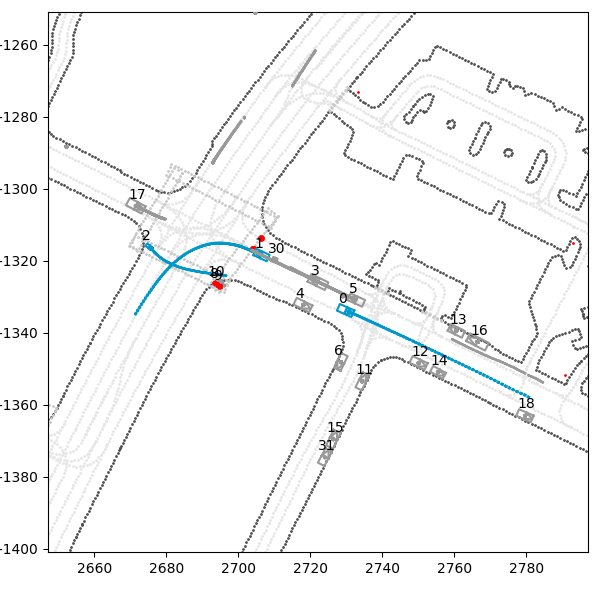

In [4]:
scenario_id, scenario = data_iter.next()
print(scenario_id)
img = visualization.plot_simulator_state(scenario, use_log_traj=True, highlight_obj = _config.ObjectType.MODELED)
mediapy.show_image(img)

In [5]:
action, action_valid = inverse_unicycle_control(scenario)

scenario_smoothed = smooth_scenario(scenario, duplicate=True)
action_smoothed, action_valid_smoothed = inverse_unicycle_control(scenario_smoothed)

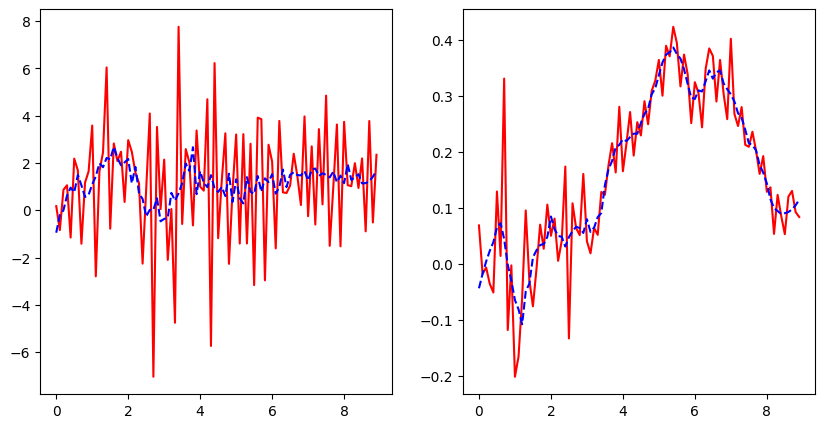

In [7]:
a = 1
t = np.arange(0, 9.0, 0.1)
valid = action_valid[a]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(t[valid], action[a][valid, 0], 'r')
axs[1]. plot(t[valid], action[a][valid, 1], 'r')
valid_smoothed = action_valid_smoothed[a]
axs[0].plot(t[valid_smoothed], action_smoothed[a][valid_smoothed, 0], 'b--')
axs[1]. plot(t[valid_smoothed], action_smoothed[a][valid_smoothed, 1], 'b--')

In [55]:
accel_grid = np.linspace(-10, 10, 16)
steering_grid = np.linspace(-1, 1, 16)

In [8]:
action, action_valid = inverse_unicycle_control(scenario_smoothed)
is_controlled = scenario.object_metadata.is_modeled | scenario.object_metadata.is_sdc
states = [env.reset(scenario)]
for i in range(states[0].remaining_timesteps):
  current_state = states[-1]
  t = current_state.timestep
  v = np.sqrt(current_state.sim_trajectory.vel_x[:,t]**2 + current_state.sim_trajectory.vel_y[:,t]**2)
  
  accel = action[:,t,0]
  steering = action[:,t,1]
  # gridify
  # accel_idx = np.searchsorted(accel_grid[1:-1], action[:,t,0])
  # steering_idx = np.searchsorted(steering_grid[1:-1], action[:,t,1])
  # accel = (accel_grid[accel_idx] + accel_grid[accel_idx+1]) / 2
  # steering = (steering_grid[steering_idx] + steering_grid[steering_idx+1]) / 2
  action_grid = np.stack([accel, steering], axis=-1)

  
  waymax_action = actor_core.WaymaxActorOutput(
            action=datatypes.Action(data=jnp.asarray(action_grid), valid=action_valid[:, t:t+1]),
            actor_state=None,
            is_controlled=is_controlled
        )
  next_state = env.step_sim_agent(current_state, [waymax_action])
  states.append(next_state)

In [9]:
imgs = []
for state in states:
  imgs.append(visualization.plot_simulator_state(state, use_log_traj=False, highlight_obj = _config.ObjectType.VALID))
mediapy.show_video(imgs, fps=10)

In [14]:
imgs = []
for state in states:
  imgs.append(visualization.plot_simulator_state(state, use_log_traj=True, highlight_obj = _config.ObjectType.VALID))
mediapy.show_video(imgs, fps=10)

In [16]:
a = np.linspace(-0.4, 0.4, 9)
np.searchsorted(a, [-0.5, -0.35, 0.35, 0.5])

9


array([0, 1, 8, 9])